# Сглаживание

 

## Введение

На предыдущих лекциях мы узнали, что:
- Временной ряд состоит из измерений, характеризующихся временными зависимостями.
- Измерения (обычно) собираются через равные интервалы.
- Временной ряд можно разложить на тренд, сезонность и остатки.
- Многие модели временных рядов требуют, чтобы данные были стационарными для составления прогнозов.

- В этой лекции мы разовьем эти знания и рассмотрим еще одну важную концепцию, называемую **сглаживанием**.
- В частности, мы рассмотрим:

1. Введение в сглаживание и почему оно необходимо.

2. Распространенные методы сглаживания.

3. Как сглаживать данные временных рядов с помощью Python и генерировать прогнозы.

In [3]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from io import BytesIO
np.random.seed(0) # reproducibility

## Сглаживание


- На процесс сбора данных часто влияет шум.
- Если шум слишком сильный, он может скрыть полезные закономерности в данных.
- Сглаживание — это хорошо известный и часто используемый метод восстановления этих закономерностей путем *отфильтровывания шума*.
- Его также можно использовать для *составления прогнозов*, проецируя восстановленные закономерности в будущее.

- Мы рассмотрим два важных метода сглаживания:
1. Простое сглаживание.
2. Экспоненциальное сглаживание.

- Начнем с генерации некоторых стационарных данных.
- Мы обсудили важность визуального осмотра временного ряда с помощью графика последовательности выполнения.
- Поэтому мы также определим функцию `run_sequence_plot` для визуализации наших данных.

In [4]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [5]:
# Generate stationary data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

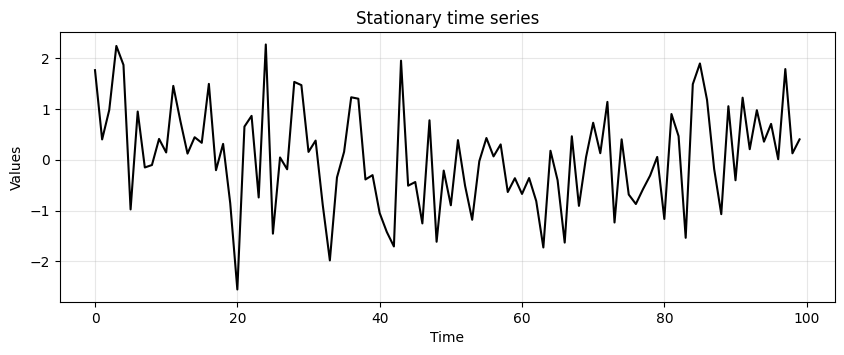

In [6]:
run_sequence_plot(time, stationary, title="Stationary time series");


---

## Простые методы сглаживания

- Существует множество методов сглаживания данных.
- Самые простые из них:
1. Простое среднее
2. Скользящее среднее
3. Взвешенное скользящее среднее

### Простое среднее

- Простое среднее — это самый базовый метод.
- Рассмотрим стационарные данные выше.
- Самый консервативный способ представления — через **среднее**.
- Среднее можно использовать для прогнозирования будущих значений временного ряда.
- Этот тип представления называется *простым средним*.

In [7]:
# find mean of series
stationary_time_series_avg = np.mean(stationary)

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

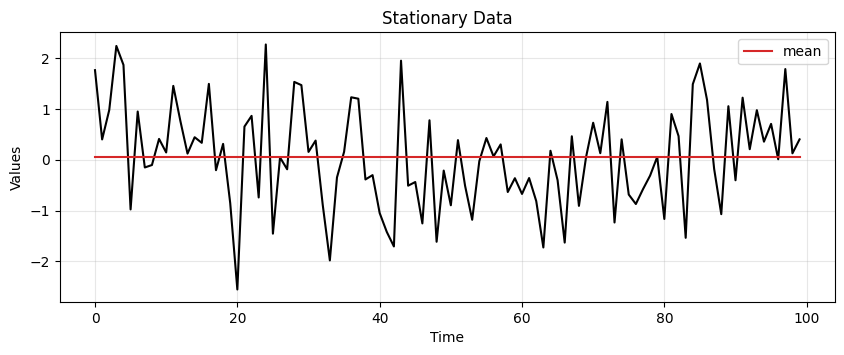

In [8]:
ax = run_sequence_plot(time, stationary, title="Stationary Data")
ax.plot(time, sts_avg, 'tab:red', label="mean")
plt.legend();

### Среднеквадратическая ошибка (MSE)

- В этом случае приближение со средним кажется разумным.
- В общем случае мы хотим измерить, насколько далека наша оценка от реальности.
- Обычный способ сделать это — вычислить *Среднеквадратичную ошибку* (MSE)

$$MSE = \frac{1}{T}\sum_{t=1}^{T} (X(t) - \hat{X}(t))^2$$

- где $X(t)$ и $\hat{X}(t)$ — истинные и оценочные значения в момент времени $t$ соответственно.

**Пример**

- Давайте рассмотрим следующий пример.
- Допустим, у нас есть временной ряд наблюдаемых значений $X = [0, 1, 3, 2]$.
- Прогнозы, данные нашей моделью, $\hat{X} = [1, 1, 2, 4]$.
- Мы вычисляем MSE следующим образом:

$$\frac{(0-1)^{2} + (1-1)^{2} + (3-2)^{2} + (2-4)^{2}}{4} = 1,5$$

- Допустим, у нас есть другая модель, которая дает нам оценку $\hat{X} = [0, 0, 1, 0]$.
- Среднеквадратическая ошибка в этом случае равна:

$$\frac{0^{2} + 1^{2} + 2^{2} + 2^{2}}{4} = 2,25$$

- MSE позволяет сравнивать различные оценки, чтобы увидеть, какая из них лучше.
- В этом случае первая модель дает нам лучшую оценку, чем вторая.
- Идея измерения того, как работает модель, важна в машинном обучении, и мы будем часто использовать ее в этом курсе.
- Давайте создадим функцию для расчета MSE, которую мы будем использовать по мере продвижения вперед.

In [9]:
def mse(observations, estimates):
    """
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    """
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"

    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)

    return mse

Давайте протестируем функцию ``mse``.

In [10]:
zeros = mse(np.array([0, 1, 3, 2]), np.array([1, 1, 2, 4]))
print(zeros)

1.5


In [11]:
ones = mse(np.array([0, 1, 3, 2]), np.array([0, 0, 1, 0]))
print(ones)

2.25


- Далее мы добавляем *тренд* к нашему стационарному временному ряду.

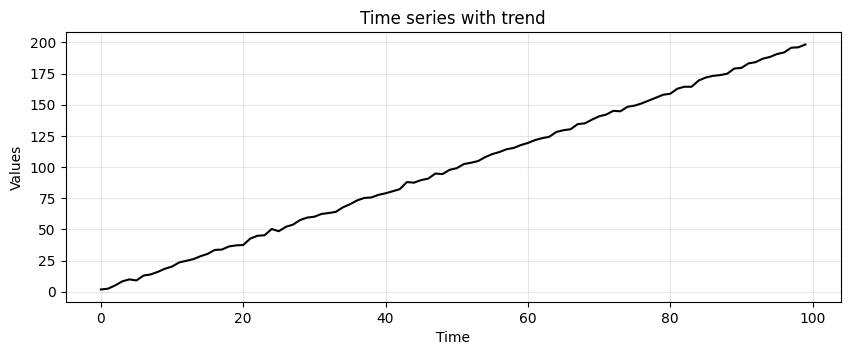

In [12]:
trend = (time * 2.0) + stationary
run_sequence_plot(time, trend, title="Time series with trend");

- Предположим, мы снова используем простое среднее значение для представления временного ряда.

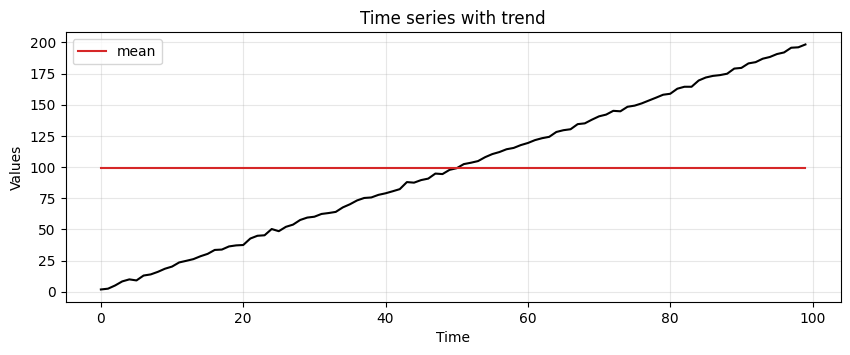

In [13]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
avg_trend = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time, avg_trend, 'tab:red', label="mean")
plt.legend();

- Очевидно, что простое среднее значение в этом случае не работает.
- Мы должны найти другие способы зафиксировать базовую закономерность в данных.
- Мы начнем с того, что называется *скользящей средней*.

### Скользящая средняя (MA)

- Скользящая средняя имеет большую чувствительность, чем простая средняя, ​​к локальным изменениям данных.
- Самый простой способ понять скользящую среднюю — на примере.
- Допустим, у нас есть следующие значения:

<img src="data\l3\values.png" style="width: 30%; display: block; margin: auto;">



- Первый шаг - выбор размера окна.
- Мы произвольно выберем размер 3.
- Затем мы начнем вычислять среднее значение для первых трех значений и сохраним результат.
- Затем мы сдвигаем окно на единицу и вычисляем среднее значение следующих трех значений.
- Мы повторяем этот процесс, пока не достигнем конечного наблюдаемого значения.

<img src="data\l3\EqWMA.gif" style="width: 40%; display: block; margin: auto;">

- Теперь давайте определим функцию для выполнения сглаживания с помощью MA.
- Затем мы сравниваем MSE, полученную путем применения простого и скользящего среднего к данным с трендом.

In [14]:
def moving_average(observations, window=3, forecast=False):
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    ma = cumulative_sum[window - 1:] / window
    if forecast:
        observations = np.append(observations, np.nan)
        ma_forecast = np.insert(ma, 0, np.nan*np.ones(window))
        return observations, ma_forecast
    else:
        return ma

In [15]:
MA_trend = moving_average(trend, window=3)

print(f"MSE:\n--------\nsimple average: {mse(trend, avg_trend):.2f}\nmoving_average: {mse(trend[2:], MA_trend):.2f}")

MSE:
--------
simple average: 3324.01
moving_average: 4.57


- Очевидно, что MA удается гораздо лучше улавливать данные тренда.
- Мы также можем построить график результата относительно фактического временного ряда.

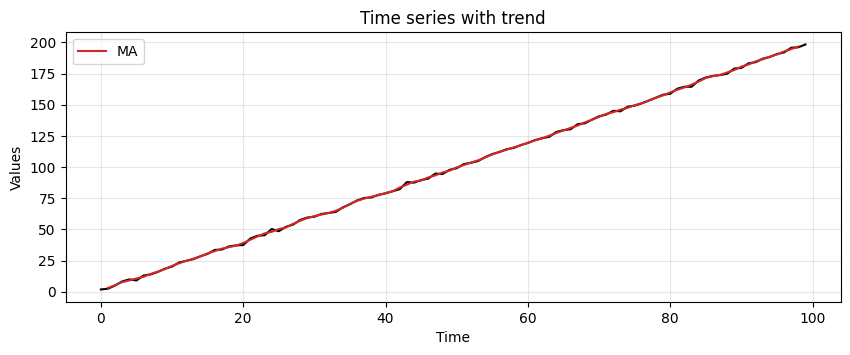

In [16]:
run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time[1:-1], MA_trend, 'tab:red', label="MA")
plt.legend();

- Обратите внимание, что выход MA короче исходных данных.
- Причина в том, что скользящее окно не центрировано на первом и последнем элементах временного ряда.
- При заданном окне размером $P$ MA будет на $P-1$ шагов короче исходного временного ряда.

In [17]:
x = np.arange(20)
print(len(moving_average(x, window=9)))

12


- Теперь мы пробуем применить МА к периодическому временному ряду, который может отражать сезонность.

In [18]:
seasonality = 10 + np.sin(time) * 10 + stationary
MA_seasonality = moving_average(seasonality, window=3)

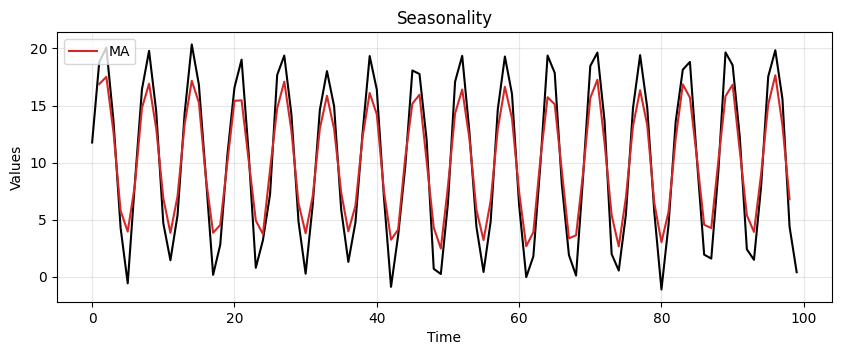

In [19]:
run_sequence_plot(time, seasonality, title="Seasonality")
plt.plot(time[1:-1], MA_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- Он не идеален, но четко улавливает периодический паттерн.
- Наконец, давайте посмотрим, как MA справляется с трендом, сезонностью и небольшим шумом.

In [20]:
trend_seasonality = trend + seasonality + stationary
MA_trend_seasonality = moving_average(trend_seasonality, window=3)

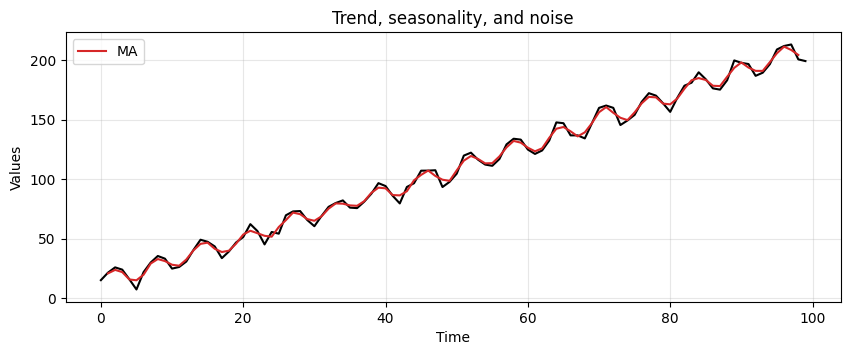

In [21]:
run_sequence_plot(time, trend_seasonality, title="Trend, seasonality, and noise")
plt.plot(time[1:-1], MA_trend_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- Этот метод выявляет ключевые закономерности в этих игрушечных наборах данных.
- Однако у него есть несколько ограничений.

1. MA присваивает равную важность всем значениям в окне, независимо от их хронологического порядка.
- По этой причине он не может уловить часто более значимые недавние тенденции.

2. MA требует выбора определенного размера окна, который может быть произвольным и не подходить для всех типов данных.
- маленькое окно может привести к шуму
- слишком большое окно может чрезмерно сгладить данные, упустив важные краткосрочные колебания.

3. MA не корректирует изменения тренда или сезонности. - Это может привести к неточным прогнозам, особенно когда эти компоненты нелинейны и зависят от времени.

### Взвешенное скользящее среднее (WMA)

- WMA придает недавним наблюдениям больший вес, чем более отдаленным.
- Это интуитивно понятно.
- Подумайте о фондовом рынке: было замечено, что сегодняшняя цена является хорошим предсказателем завтрашней цены.
- Применяя неравные веса к прошлым наблюдениям, мы можем контролировать, насколько каждое из них влияет на будущий прогноз.

- Существует много способов задать веса.
- Например, мы могли бы определить их с помощью следующей системы уравнений:

$$
\begin{cases}
& w_1 + w_2 + w_3 = 1\\
& w_2 = (w_1)^2 \\
& w_3 = (w_1)^3
\end{cases}
$$

- Это дает следующие веса:

$$
\begin{aligned}
& w_1 \approx 0.543 & \text{веса, связанные с $t-1$}\\
& w_2 \approx 0.294 & \text{веса, связанные с $t-2$} \\
& w_3 \approx 0.16 & \text{веса, связанные с $t-3$}
\end{aligned}
$$

<img src="data\l3\ExpWMA.gif" style="width: 40%; display: block; margin: auto;">

**📝Примечание**

- Существует множество методов поиска оптимальной схемы взвешивания на основе данных и поставленной задачи.
- Полное обсуждение выходит за рамки лекции.

### Прогнозирование с помощью MA

- Вместо того, чтобы вытаскивать присущий шаблон из ряда, можно использовать функции сглаживания для создания *прогнозов*.
- Прогноз для следующего временного шага вычисляется следующим образом:

$$\hat{X}(t+1) = \frac{X(t) + X(t-1) + \dots + X(t-P+1)}{P}$$

- где $P$ — размер окна MA.

- Рассмотрим следующий временной ряд $X= [1, 2, 4, 8, 16, 32, 64]$.
- В частности, мы применяем процесс сглаживания и используем полученное значение в качестве прогноза для следующего временного шага.
- С помощью техники MA и размера окна $P=3$ мы получаем следующий прогноз.

In [22]:
x = np.array([1, 2, 4, 8, 16, 32, 64])
ma_x, ma_forecast = moving_average(x, window=3, forecast=True)

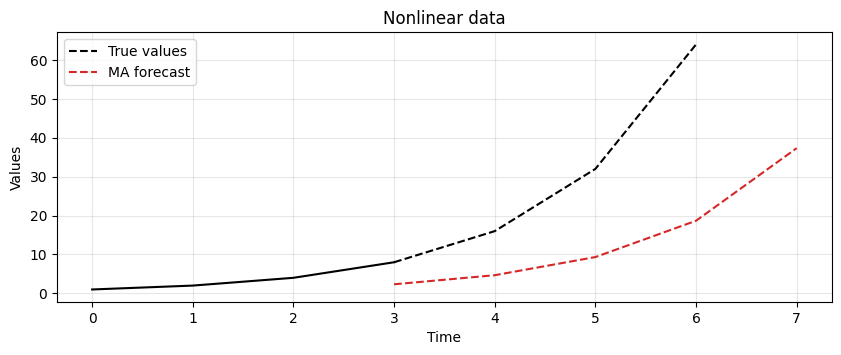

In [23]:
t = np.arange(len(ma_x))
run_sequence_plot(t[:-4], ma_x[:-4], title="Nonlinear data")
plt.plot(t[-5:], ma_x[-5:], 'k', label="True values", linestyle='--')
plt.plot(t, ma_forecast, 'tab:red', label="MA forecast", linestyle='--')
plt.legend(loc='upper left');

- Результат показывает, что MA отстает от фактического сигнала.
- В этом случае она не успевает за изменениями тренда.
- Отставание MA также отражается в прогнозах, которые она выдает.

- Давайте сосредоточимся на [формуле прогнозирования](#forecasting-with-ma), которую мы только что определили.
- Хотя ее легко понять, одно из ее свойств может быть неочевидным.
- Какая задержка связана с этой техникой?
- Другими словами, через сколько временных шагов мы видим локальное изменение в базовом сигнале?

- Ответ: $\frac{(P+1)}{2}$.
- Например, предположим, что вы усредняете последние 5 значений, чтобы сделать следующий прогноз.
- Тогда прогнозируемое значение, которое наиболее точно отражает текущее значение, появится после $\frac{5+1}{2} = 3$ временных шагов.
- Очевидно, что задержка увеличивается по мере увеличения размера окна для усреднения.

- Можно уменьшить размер окна, чтобы получить более отзывчивую модель.
- Однако слишком маленький размер окна будет преследовать шум в данных, а не извлекать закономерность.
- Существует компромисс между *отзывчивостью* и *устойчивостью к шуму*.
- Лучший ответ лежит где-то посередине и требует тщательной настройки, чтобы определить, какая настройка лучше всего подходит для данного набора данных и рассматриваемой проблемы.

- Давайте приведем практический пример, чтобы продемонстрировать этот компромисс.
- Мы сгенерируем некоторые игрушечные данные и применим MA с разными размерами окна.
- Чтобы все было более понятно, мы снова генерируем данные с трендом и сезонностью, но добавляем больше шума.

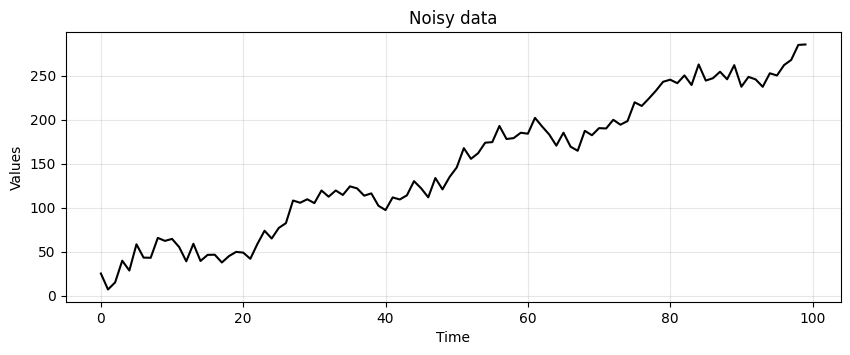

In [24]:
noisy_noise = np.random.normal(loc=0, scale=8.0, size=len(time))
noisy_trend = time * 2.75
noisy_seasonality = 10 + np.sin(time * 0.25) * 20
noisy_data = noisy_trend + noisy_seasonality + noisy_noise

run_sequence_plot(time, noisy_data, title="Noisy data");

In [25]:
# Compute MA with different window sizes
lag_2 = moving_average(noisy_data, window=3)
lag_3 = moving_average(noisy_data, window=5)
lag_5 = moving_average(noisy_data, window=9)
lag_10 = moving_average(noisy_data, window=19)

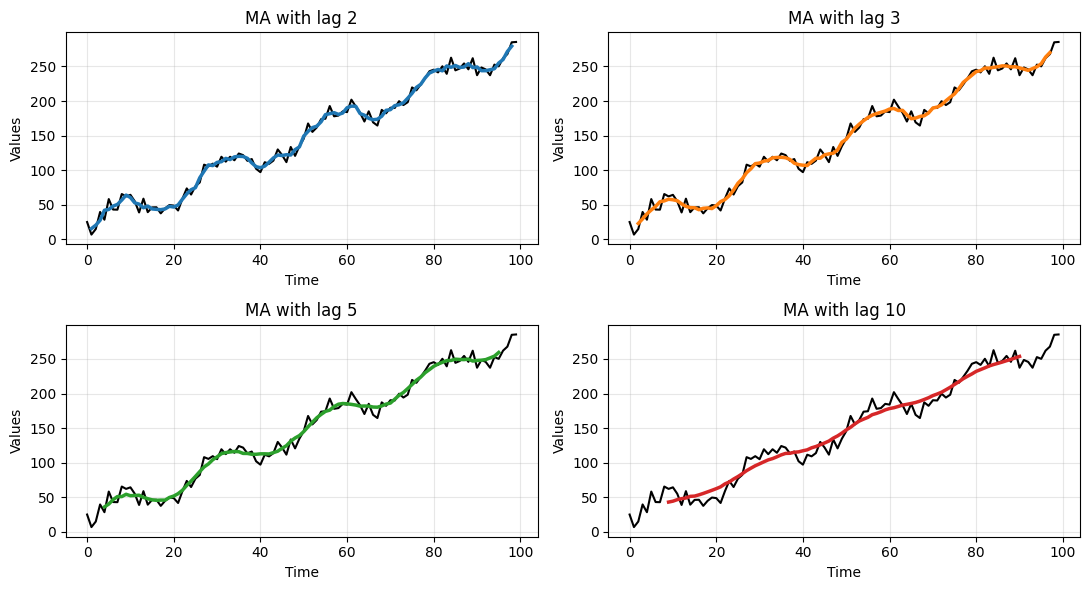

In [26]:
_, axes = plt.subplots(2,2, figsize=(11,6))
axes[0,0] = run_sequence_plot(time, noisy_data, title="MA with lag 2", ax=axes[0,0])
axes[0,0].plot(time[1:-1], lag_2, color='tab:blue', linewidth=2.5)
axes[0,1] = run_sequence_plot(time, noisy_data, title="MA with lag 3", ax=axes[0,1])
axes[0,1].plot(time[2:-2], lag_3, color='tab:orange', linewidth=2.5)
axes[1,0] = run_sequence_plot(time, noisy_data, title="MA with lag 5", ax=axes[1,0])
axes[1,0].plot(time[4:-4], lag_5, color='tab:green', linewidth=2.5)
axes[1,1] = run_sequence_plot(time, noisy_data, title="MA with lag 10", ax=axes[1,1])
axes[1,1].plot(time[9:-9], lag_10, color='tab:red', linewidth=2.5)
plt.tight_layout();

- Очевидно, что чем больше размер окна, тем сглаженнее данные.
- Это позволяет избавиться от шума, но в конечном итоге сглаживается и базовый сигнал.

### Прогнозирование с помощью WMA

- Далее мы используем WMA для создания прогнозов.
- Предыдущая [формула прогнозирования](#forecasting-with-ma) изменена для различного взвешивания прошлых наблюдений в окне:

$$\hat{X}(t+1) = \frac{w_1 \cdot X(t) + w_2 \cdot X(t-1) + \dots + w_P \cdot X(t-P+1)}{P}$$

In [27]:
def weighted_moving_average(observations, weights, forecast=False):

    if len(weights) != len(observations[0:len(weights)]):
        raise ValueError("Length of weights must match the window size")

    # Normalize weights
    weights = np.array(weights) / np.sum(weights)

    # Initialize the result array
    result = np.empty(len(observations)-len(weights)//2)
    result[:] = np.nan

    # Calculate weighted moving average
    for i in range(len(weights)//2, len(result)):
        window = observations[i-(len(weights)//2):i+len(weights)//2+1]
        result[i] = np.dot(window, weights)

    # Handle forecast option
    if forecast:
        result = np.insert(result, 0, np.nan*np.ones(len(weights)//2+1))
        observations = np.append(observations, np.nan*np.ones(len(weights)//2))
        return observations, result
    else:
        return result

- Повторяем эксперимент на том же временном ряду $X= [1, 2, 4, 8, 16, 32, 64]$.
- Мы будем использовать набор весов, который мы определили ранее, `[0.160, 0.294, 0.543]`.

In [28]:
weights = np.array([0.160, 0.294, 0.543])
wma_x, wma_forecast = weighted_moving_average(x, weights, forecast=True)

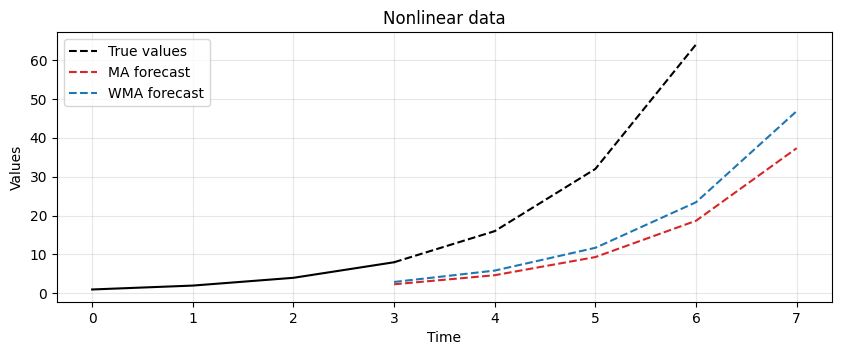

In [29]:
t = np.arange(len(wma_x))
run_sequence_plot(t[:-4], ma_x[:-4], title="Nonlinear data")
plt.plot(t[-5:], ma_x[-5:], 'k', label="True values", linestyle='--')
plt.plot(t, ma_forecast, 'tab:red', label="MA forecast", linestyle='--')
plt.plot(t, wma_forecast, 'tab:blue', label="WMA forecast", linestyle='--')
plt.legend(loc='upper left');

- WMA решает некоторые проблемы MA.
- Он более чувствителен к локальным изменениям.
- Более гибок, так как может регулировать важность различных временных шагов.
- Не требует фиксированного размера окна, так как применяет экспоненциально уменьшающийся вес ко всем прошлым наблюдениям.
- Однако ему все еще трудно угнаться за нелинейными и быстро меняющимися тенденциями... Есть значительное отставание.

## Экспоненциальное сглаживание

Существует три основных метода экспоненциального сглаживания:

|Тип | Захват тренда | Захват сезонности|
|:----:|:--------------:|:--------------------:|
|Одиночное экспоненциальное сглаживание | ❌ | ❌ |
|Двойное экспоненциальное сглаживание | ✅ | ❌ |
|Тройное экспоненциальное сглаживание | ✅ | ✅ |

### Одинарное экспоненциальное сглаживание

- 💡 Полезно, если в ваших данных отсутствует тренд и сезонность, и вы хотите приблизительно извлечь закономерности.
- Это аналогично WMA, которую мы видели ранее.
- Основная формула:

$$S(t) = \alpha X(t) + (1-\alpha)S(t-1)$$

- где:
- $S(t)$ - сглаженное значение в момент времени *t*,
- $\alpha$ - константа сглаживания,
- $X(t)$ - значение ряда в момент времени *t*.

Раскрывая формулу, получаем:

$$
\begin{aligned}
S(0) &= \alpha X(0) \\ S(1) &= \alpha X(1) + (1 - \alpha)S(0) = \alpha X(1) + \alpha(1 - \alpha)X(0) \\
S(2) & = \alpha X(2) + (1 - \alpha)S(1) = \alpha X(2) + (1 - \alpha)[\alpha X(1) + \alpha(1 - \alpha)X(0)]\\
& = \alpha X(2) + \alpha(1 - \alpha)X(1) + \alpha(1 - \alpha)^2 X(0)
\end{aligned}
$$

Формула для общего временного шага $\tau$ выглядит так:

$$ S(\tau) = \sum_{t=0}^{\tau} \alpha(1 - \alpha)^{\tau-t}X(t) $$


#### Инициализация

- Существует множество стратегий инициализации.
- Простая из них — установить $S(0) = X(0)$.
- Другая стратегия — найти среднее значение первой пары наблюдений, например, $S(0) = \frac{X(0) + X(1) + X(2)}{3}$.
- После инициализации можно использовать правило обновления выше для расчета всех значений.
- На практике мы не выполняем этот процесс вручную, а используем функции в ``statsmodels``.

#### Установка $\alpha$
- Выбор оптимального значения для $\alpha$ также выполняется ``statsmodels``.
- Решатель использует метрику, например MSE, для поиска оптимального $\alpha$.
- Даже если мы не выбираем значение вручную, полезно иметь общее представление о том, что происходит под капотом.

### Двойное экспоненциальное сглаживание

- 💡 Оно обладает всеми преимуществами одинарного экспоненциального сглаживания, а также способностью улавливать тренд.

$$
\begin{aligned}
S(t) = \alpha X(t) + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values of the series} \\
b(t) = \beta\big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\
\hat{X}(t+1) = S(t) + b(t) & \hspace{2cm} \text{Forecasts}
\end{aligned}
$$

- Параметр $\beta \in [0,1]$ контролирует затухание влияния изменения тренда.

**Инициализация**

- $S(0) = X(0)$.
- $b(0) = X(1) - X(0)$.
- Возможны иные подходы к инициализации.

**Прогноз на один шаг вперед**
- $\hat{X}(t+\tau) = S(t) + \tau b(t)$.

### Тройное экспоненциальное сглаживание

- 💡 Оно обладает всеми преимуществами двойного экспоненциального сглаживания, а также способностью моделировать сезонность.
- Это достигается путем добавления третьего компонента, который сглаживает сезонность длиной $L$.
- В модели есть два варианта:
- аддитивная сезонность,
- мультипликативная сезонность.

**Additive seasonality model**

- This method is preferred when the seasonal variations are roughly constant through the series.

$$
\begin{aligned}
S(t) = \alpha \big(X(t) - c(t-L)\big) + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values} \\
b(t) = \beta\big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\
c(t) = \gamma \big(X(t) - S(t-1) - b(t-1)\big) + (1-\gamma)c(t-L) & \hspace{2cm} \text{Seasonal correction} \\
\hat{X}(t+\tau) = S(t) + \tau b(t) + c(t-L + 1 + (\tau - 1)\text{mod}(L)) & \hspace{2cm} \text{Forecasts}
\end{aligned}
$$

**Multiplicative seasonality model**

- This method is preferred when the seasonal variations are changing proportional to the level of the series.

$$
\begin{aligned}
S(t) = \alpha \frac{X(t)}{c(t-L)} + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values} \\
b(t) = \beta \big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\
c(t) = \gamma \left( \frac{X(t)}{S(t)} \right) + (1-\gamma)c(t-L) & \hspace{2cm} \text{Seasonal correction} \\
\hat{X}(t+\tau) = \big( S(t) + \tau b(t) \big)c(t-L + 1 + (\tau - 1)\text{mod}(L)) & \hspace{2cm} \text{Forecasts}
\end{aligned}
$$

**Initialization**

- $b(0) = \frac{1}{L} \left( \frac{X(L+1) - X(1)}{L} + \frac{X(L+2) - X(2)}{L} + \dots + \frac{X(L+L) - X(L)}{L} \right)$
- $c(t) = \frac{1}{N} \sum_{j=1}^N \frac{X(L(j-1)+t)}{A_j}$ for $t=1,2,\dots,L$, where $N$ is the total number of seasonal cycles in the data and $A_j = \frac{\sum_{t=1}^L  X(2(j-1)+t)}{L}$

---

## Экспоненциальное сглаживание в Python

 Давайте теперь посмотрим, как выполнить сглаживание в Python.
- Как мы уже делали раньше, мы воспользуемся ``statsmodels``, чтобы он сделал всю тяжелую работу за нас.
- Davayte t

- Мы будем использовать тот же временной ряд с трендом и сезонностью для сравнения простого среднего, одинарного, двойного и тройного экспоненциального сглаживания.
- Мы удержим последние 5 выборок из набора данных (т. е. они станут *тестовым набором*).
- Мы сравним прогнозы, сделанные моделями, с этими значениями.

In [30]:
# Train/test split
train = trend_seasonality[:-5]
test = trend_seasonality[-5:]

### Простое среднее

- Это очень грубая модель, если говорить мягко.
- Ее можно использовать как базовую.
- Любая модель, которую мы попробуем использовать в будущем, должна работать намного лучше этой.

In [31]:
# find mean of series
trend_seasonal_avg = np.mean(trend_seasonality)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float')

# mse
simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [109.21734351 109.21734351 109.21734351 109.21734351 109.21734351]
MSE:  9549.121874364564


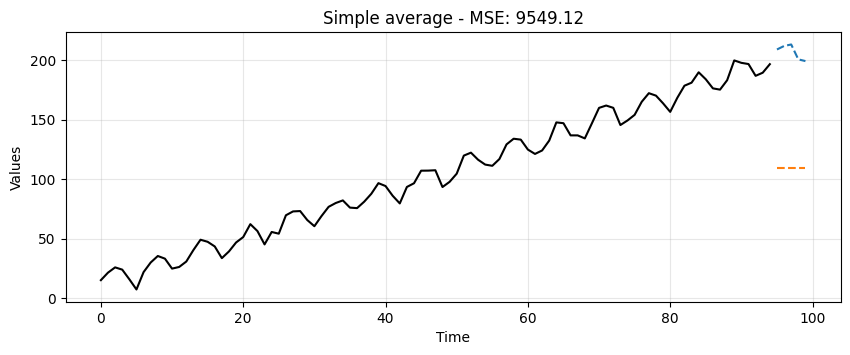

In [32]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple average - MSE: {simple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], simple_avg_preds, color='tab:orange', linestyle="--", label="preds");

### Single Exponential

In [33]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [196.61657923 196.61657923 196.61657923 196.61657923 196.61657923]
MSE:  136.2446911548019


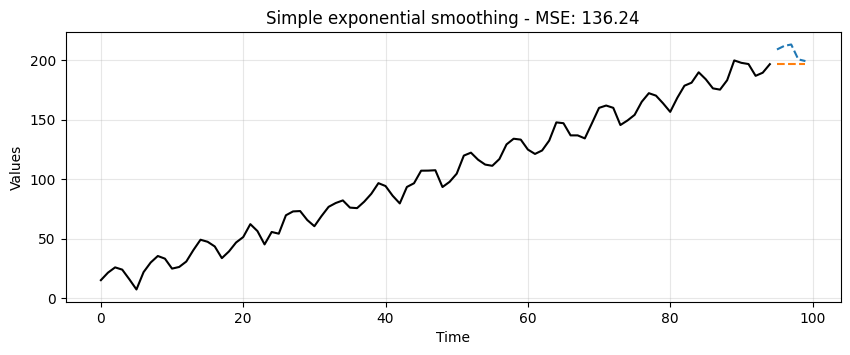

In [34]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple exponential smoothing - MSE: {single_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], single_preds, color='tab:orange', linestyle="--", label="preds");

- Это, конечно, лучше, чем метод простого среднего, но все еще довольно грубо.
- Обратите внимание, что прогноз представляет собой просто горизонтальную линию.
- Одинарное экспоненциальное сглаживание не может уловить ни тренд, ни сезонность.

### Double Exponential

In [35]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [198.62600845 200.63543764 202.64486683 204.65429602 206.66372521]
MSE:  82.95676998059635


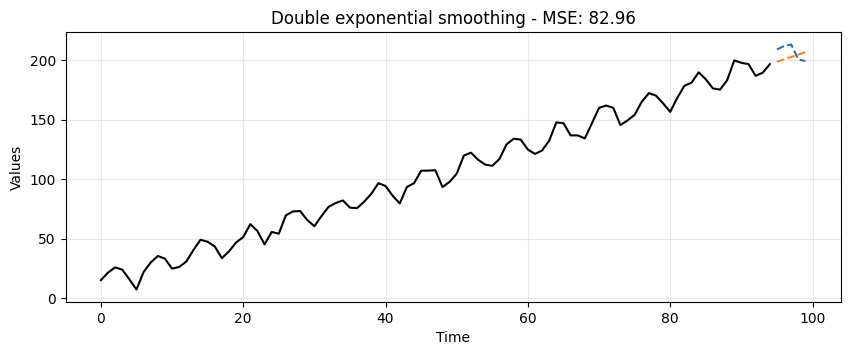

In [36]:
ax = run_sequence_plot(time[:-5], train, title=f"Double exponential smoothing - MSE: {double_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], double_preds, color='tab:orange', linestyle="--", label="preds");

- Двойное экспоненциальное сглаживание может улавливать тренд, что мы здесь и видим.
- Это значительный скачок, но пока не совсем тот прогноз, который мы хотели бы получить.

### Тройная экспонента

In [37]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [204.46882072 207.03271679 215.74682077 209.8844631  202.24074261]
MSE:  28.938843538165578


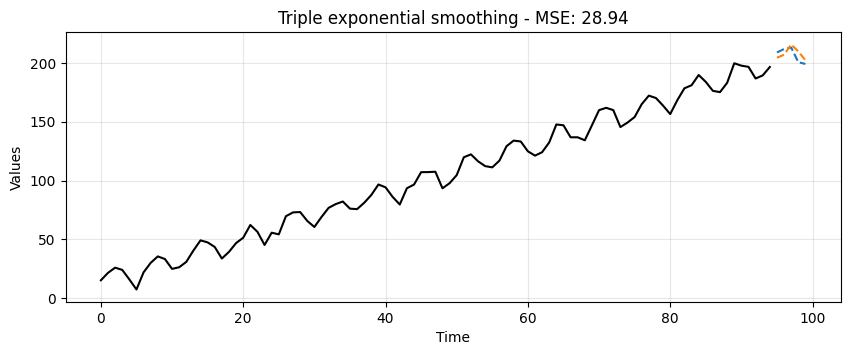

In [38]:
ax = run_sequence_plot(time[:-5], train, title=f"Triple exponential smoothing - MSE: {triple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], triple_preds, color='tab:orange', linestyle="--", label="preds");

 Тройное экспоненциальное сглаживание улавливает тренд и сезонность.
- Очевидно, что это наиболее подходящий подход для этих данных.
- Мы можем суммировать результаты в следующей таблице:

In [39]:
data_dict = {'MSE':[simple_mse, single_mse, double_mse, triple_mse]}
df = pd.DataFrame(data_dict, index=['simple', 'single', 'double', 'triple'])
print(df)

                MSE
simple  9549.121874
single   136.244691
double    82.956770
triple    28.938844


---

## Резюме

В этой лекции мы узнали

1. Что такое сглаживание и почему оно необходимо.
2. Некоторые распространенные методы сглаживания.
3. Базовое понимание того, как сглаживать данные временных рядов с помощью Python и генерировать прогнозы.
---

In [60]:
from scipy.fft import fft

def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes

## Упражнения

Загрузите следующие два временных ряда.

In [40]:
resp1 = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts1.npy?download=1")
resp1.raise_for_status()
smoothing_ts1 = np.load(BytesIO(resp1.content))

In [41]:
resp2 = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts4_4.npy?download=1")
resp2.raise_for_status()
smoothing_ts2 = np.load(BytesIO(resp2.content))

Используя то, что вы узнали в этой и предыдущих лекциях, выполните следующие действия.

1. Создайте две временные переменные с именами `mytime1` и `mytime2`, которые начинаются с 0 и имеют такую ​​же длину, как и каждый набор данных.
2. Разделите каждый набор данных на обучающий и тестовый наборы (в качестве теста используйте последние 5 наблюдений).
3. Определите тренд и сезонность, если они присутствуют.
4. Определите, являются ли тренд и/или сезонность аддитивными или мультипликативными, если они присутствуют.
5. Создайте сглаженную модель на обучающем наборе и используйте ее для прогнозирования на тестовом наборе.
6. Рассчитайте MSE на тестовых данных.
7. Нанесите на график обучающие данные, тестовые данные и прогноз вашей модели для каждого набора данных.

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(10, 7))

    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')

    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')

    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')

    plt.show()

1.

In [52]:
mytime1 = np.arange(len(smoothing_ts1))
mytime2 = np.arange(len(smoothing_ts2))

2.

In [53]:
train1 = smoothing_ts1[:-5]
test1 = smoothing_ts1[-5:]

train2 = smoothing_ts2[:-5]
test2= smoothing_ts2[-5:]

3-4.

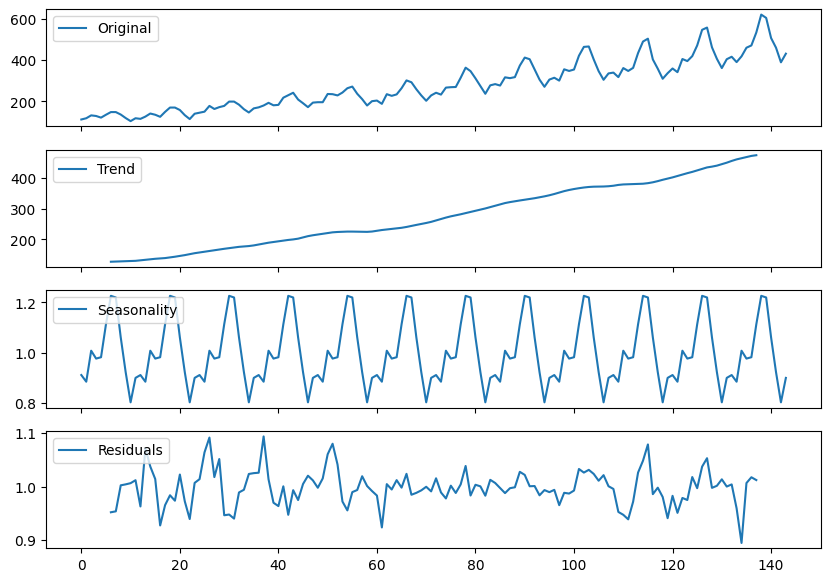

In [54]:
seas_decomp_plots(smoothing_ts1, seasonal_decompose(x=smoothing_ts1, model='multiplicative', period=12))

In [77]:
_, _, _ = fft_analysis(smoothing_ts1)

Dominant Frequency: 0.083
Dominant Period: 12.00 time units


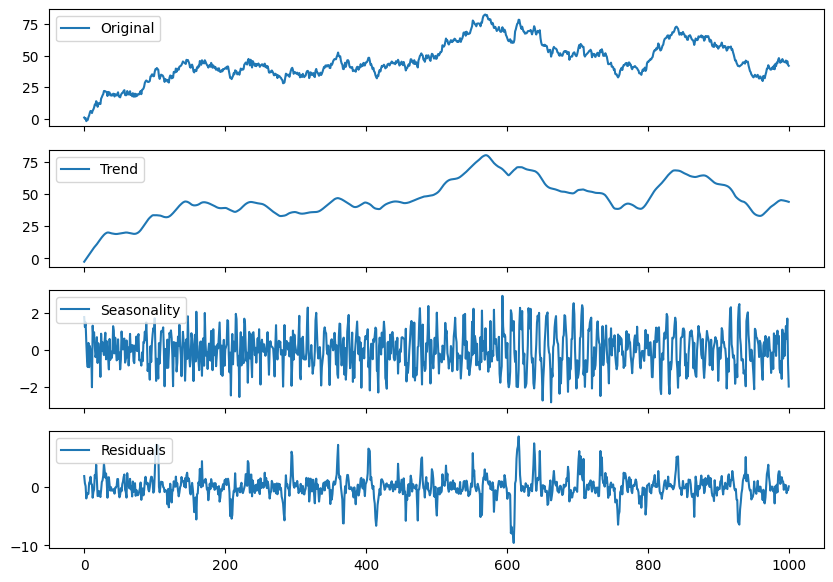

In [55]:
seas_decomp_plots(smoothing_ts2, STL(endog=smoothing_ts2, period=12, robust=True).fit())

In [78]:
_, _, _ = fft_analysis(smoothing_ts2)

Dominant Frequency: 0.001
Dominant Period: 1000.00 time units


5-7.

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing

In [79]:
triple1 = ExponentialSmoothing(train1,
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)# multiplicative  additive
triple_preds1 = triple1.forecast(len(test1))
triple_mse1 = mse(test1, triple_preds1)
print("Predictions: ", triple_preds1)
print("MSE: ", triple_mse1)

Predictions:  [626.70202518 512.59677691 447.67716677 392.50387394 432.18184494]
MSE:  126.70090844007423


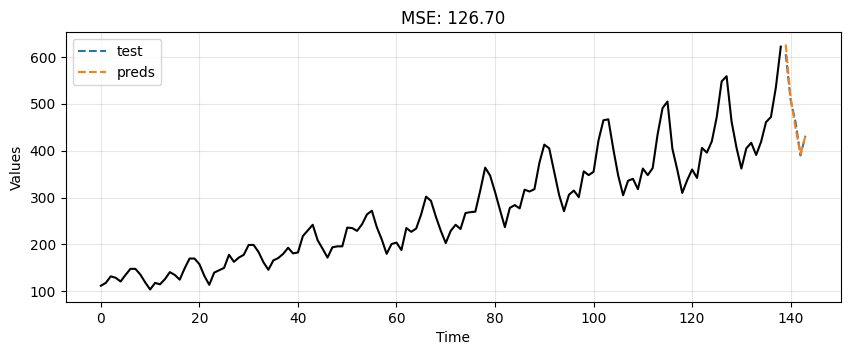

In [80]:
ax = run_sequence_plot(mytime1[:-5], train1, title=f"MSE: {triple_mse1:.2f}")
ax.plot(mytime1[-5:], test1, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime1[-5:], triple_preds1, color='tab:orange', linestyle="--", label="preds")
plt.legend()
plt.show()

In [82]:
# find mean of series
train2_avg = np.mean(train2)

# create array of mean value equal to length of time array
avg_preds2 = np.full(shape=len(test2), fill_value=train2_avg, dtype='float')

# mse
simple_mse2 = mse(test2, avg_preds2)

# results
print("Predictions: ", avg_preds2)
print("MSE: ", simple_mse2)

Predictions:  [48.61111355 48.61111355 48.61111355 48.61111355 48.61111355]
MSE:  23.916404905042693


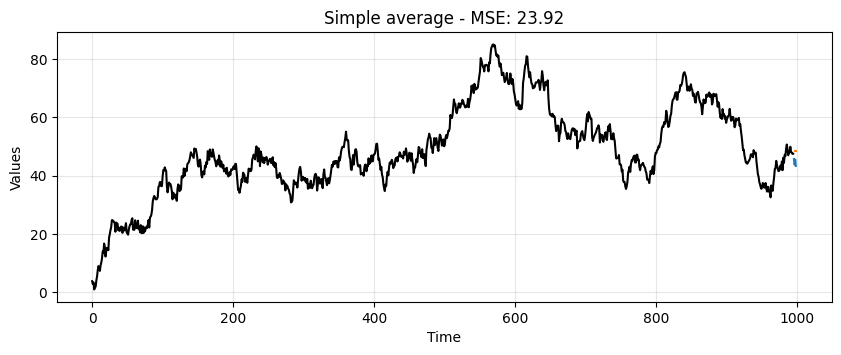

In [85]:
ax = run_sequence_plot(mytime2[:-5], train2, title=f"Simple average - MSE: {simple_mse2:.2f}")
ax.plot(mytime2[-5:], test2, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime2[-5:], avg_preds2, color='tab:orange', linestyle="--", label="preds");

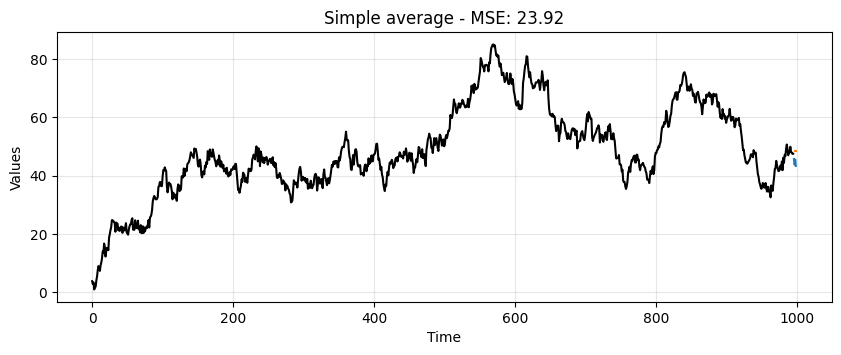

In [92]:
ax = run_sequence_plot(mytime2[:-5], train2, title=f"Simple average - MSE: {simple_mse2:.2f}")
ax.plot(mytime2[-5:], test2, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime2[-5:], avg_preds2, color='tab:orange', linestyle="--", label="preds");

In [81]:
from statsmodels.tsa.api import Holt

double = Holt(train2).fit(optimized=True)
double_preds = double.forecast(len(test2))
double_mse = mse(test2, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [47.55116625 47.57057457 47.58998289 47.60939121 47.62879953]
MSE:  15.594041008958365


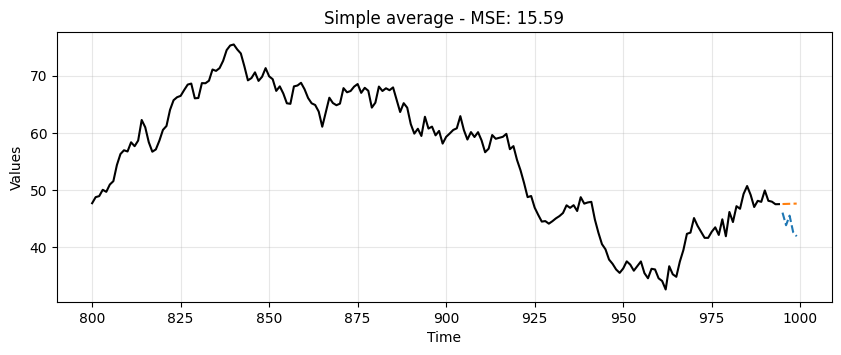

In [94]:
ax = run_sequence_plot(mytime2[800:-5], train2[800:], title=f"Simple average - MSE: {double_mse:.2f}")
ax.plot(mytime2[-5:], test2, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime2[-5:], double_preds, color='tab:orange', linestyle="--", label="preds");

-----------------------------------------------------------------------------------------------------------------------------------------

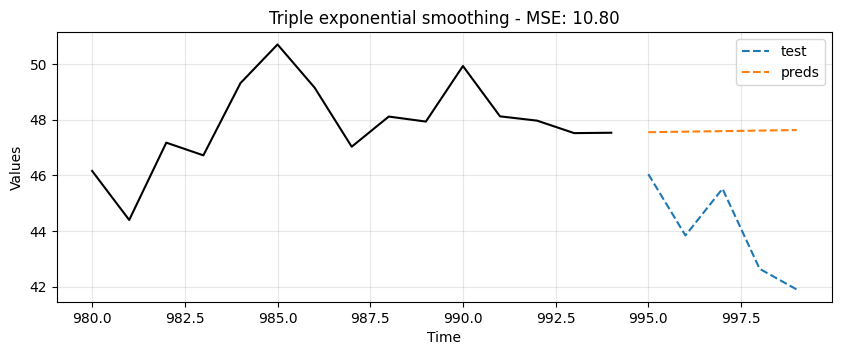

In [76]:
ax = run_sequence_plot(mytime2[980:-5], train2[980:], title=f"Triple exponential smoothing - MSE: {triple_mse2:.2f}")
ax.plot(mytime2[-5:], test2, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime2[-5:], double_preds, color='tab:orange', linestyle="--", label="preds")
plt.legend()
plt.show()